# 10 - Extracting Objects: Base Tutorial

All data for a single HETDEX observation (a dither set of three exposures), is stored in one HDF5 file. This file contains the sky-subtracted, flux-calibrated, and rectified spectra for each fiber.  The extension is called "calfib" in the Fibers table and the units are ergs/s/cm^2 integrated over a 2A bin.  To get to ergs/s/cm^2/A, simply divide by 2.

In this notebook we will demonstrate extracting sources at a given RA, Dec with a variety of extraction methods.  This tutorial can inform users how the extraction works and then the user can build an efficient use of this tool for large numbers of extractions.

## Importing Extract

To use HETDEX_API, please follow the instructions on: https://github.com/grzeimann/HETDEX_API/tree/master/notebooks

We have tried to limit the dependencies for this package, but if you are having trouble using this notebook, please contact: grzeimann@gmail.com

First we will import a few plotting tools, coordinate tools, and the Extract API.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval

import astropy.units as u
from astropy.coordinates import SkyCoord

from hetdex_api.extract import Extract

## Initiate the Fibers Class

Extract is a class module and upon initiazion, the class loads an atmospheric differential refraction model, and sets the rectified wavelength for the calfib extesion in the Shot HDF5 file.  More or less, not much happens at this step, but it is necessary to abstract the initialize class as a variable, in this case, E.

In [2]:
E = Extract()

## Load a shot

Loading a shot for the Extract class is the same as for the Fibers class as it calls on the Fibers class directly.  This will take a few seconds and likely pumps out a few warnings.  The warnings are due to the initialization of a SkyCoord object with RA's and/or Dec's outside of the valid range.  Meaning, some fibers don't have valid RA's and Dec's.  

In [3]:
E.load_shot('20190105v014')

/home1/03730/gregz/.local/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/03730/gregz/.local/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home1/03730/gregz/.local/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home1/03730/gregz/.local/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


## Load SDSS objects with Spectra

To use astroquery's SDSS class, please first "pip install --user astroquery" in your terminal on stampede2.  You only need to do this once.  

We will load all of the SDSS sources with spectra and compare our extracted spectra to them.

In [4]:
# Find the RA and Dec of the shot
RA = E.fibers.hdfile.root.Shot.cols.ra[:][0]
Dec = E.fibers.hdfile.root.Shot.cols.dec[:][0]

# Load SDSS from astroquery
from astroquery.sdss import SDSS
pos = SkyCoord(RA * u.deg, Dec * u.deg, frame='fk5')

# Query all sdss objects with spectra within 11' of the central RA and Dec
xid = SDSS.query_region(pos, radius=11*u.arcmin, spectro=True,
                        photoobj_fields=['ra', 'dec', 'u', 'g', 'r', 'i', 'z'],
                        specobj_fields=['plate', 'mjd', 'fiberID', 'z',
                                        'specobjid', 'run2d', 'instrument'])

# Download their spectra (please use this sparingly as there are better ways to get a log of SDSS spectra)
sp = SDSS.get_spectra(matches=xid)

# Printing table of SDSS sources with spectra
print(xid)

/home1/03730/gregz/.local/lib/python2.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
/home1/03730/gregz/.local/lib/python2.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


       ra               dec           u     ... run2d  instrument
---------------- ----------------- -------- ... ------ ----------
31.4414320424315 0.426374217708174 19.15393 ...     26       SDSS
31.2743496223767  0.42141951116444 17.33615 ... v5_7_0       BOSS
31.2743496223767  0.42141951116444 17.33615 ...     26       SDSS
31.2743496223767  0.42141951116444 17.33615 ...     26       SDSS
31.2743496223767  0.42141951116444 17.33615 ...     26       SDSS
31.2304810707568 0.457712997204429 24.77709 ... v5_7_0       BOSS
31.4432322647346 0.626068392843717 17.93835 ...     26       SDSS
31.4432322647346 0.626068392843717 17.93835 ...     26       SDSS
 31.334730921565 0.486622193892919 20.63623 ...     26       SDSS
31.4749252925103 0.608719858821244  19.3389 ...     26       SDSS
             ...               ...      ... ...    ...        ...
31.5087793221678 0.442636120576673 20.19677 ...     26       SDSS
31.4326813660541 0.604974651351535 20.95049 ...     26       SDSS
 31.528620

## Using Extract Class

In [5]:
import numpy as np

# Build aperture PSF for aperture extraction
fixed_aperture = 4.

# Using box size of 10.5 (length of box side) and pixel scale of 0.25
# To see documentation use: help(E.tophat_psf)
aperture = E.tophat_psf(fixed_aperture, 10.5, 0.25)

# Get curve of growth from VIRUS PSF for the given loaded shot
# To see documentation use: help(E.model_psf)
psf = E.model_psf(gmag_limit=22.)
r, curve_of_growth = E.get_psf_curve_of_growth(psf)
correction = 1. / np.interp(fixed_aperture, r, curve_of_growth)
E.log.info('PSF correction for radius, %0.1f", is: %0.2f' % (fixed_aperture, 
                                                             correction))

/home1/03730/gregz/.local/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)
/home1/03730/gregz/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 14 results
  r = func(a, **kwargs)
[INFO - 2019-03-21 14:26:11,577] PSF model StarID: 1237663784747926556 too faint: 24.87
/home1/03730/gregz/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 25 results
  r = func(a, **kwargs)
[INFO - 2019-03-21 14:26:11,664] PSF model StarID: 1237663784747991106 on edge: -10.14, -28.97
[INFO - 2019-03-21 14:26:11,695] PSF model StarID: 1237663784747991128 on edge: 1.23, 25.02
[INFO - 2019-03-21 14:26:11,698] PSF model StarID: 1237663784747991130 too faint: 24.12
/home1/03730/gregz/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encounte

Let's check out the aperture extraction "psf" and the spatial PSF measured from the VIRUS fibers.

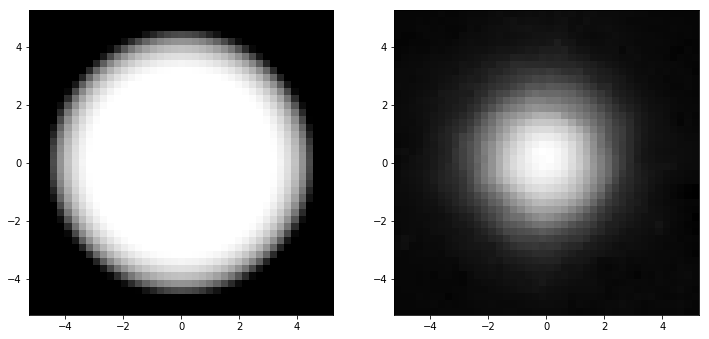

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
from astropy.visualization import AsinhStretch, ImageNormalize, MinMaxInterval 
i = 0
for image, title in zip([aperture, psf], ['Aperture', 'PSF']):
    norm = ImageNormalize(image[0], interval=MinMaxInterval(),
                      stretch=AsinhStretch())
    extent = [image[1].min(), image[1].max(), image[2].min(), image[2].max()]
    ax[i].imshow(image[0], norm=norm, origin="lower",cmap=plt.get_cmap('gray'),interpolation="none", extent=extent)
    i += 1

## Extracting Sources

Now that we have a psf or aperture to extract with, we can build an extraction example.

First, let's grab the fiber information we want and look at the source.

/home1/03730/gregz/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 413 results
  r = func(a, **kwargs)


[-5.375, 5.375000000000002, -5.375, 5.375]

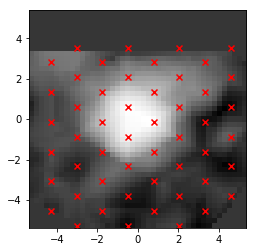

In [7]:
# Pick a coordinate to extract (here I'm cheating because I know the coordinate is a source in the VIRUS FoV)
# For fun, you can change this index to 31 or 8
index = 22
coord = SkyCoord(xid['ra'][index] * u.deg, xid['dec'][index] * u.deg)

# Let's grab the fiber information within a given radius
# To get more info: help(E.get_fiberinfo_for_coord)
info_result = E.get_fiberinfo_for_coord(coord, radius=7.)

# info_result will be None if the location doesn't have at least 5 fibers within the radius.
# Build your code checks to catch when info_result is None
ifux, ifuy, xc, yc, ra, dec, data, error, mask = info_result


image = E.make_collapsed_image(xc, yc, ifux, ifuy, data, mask,
                               scale=0.25, seeing_fac=1.5, boxsize=10.75,
                               wrange=[4900, 5300], nchunks=3,
                               convolve_image=False)
norm = ImageNormalize(image[0], interval=MinMaxInterval(),
                      stretch=AsinhStretch())
extent = [image[1].min(), image[1].max(), image[2].min(), image[2].max()]
plt.imshow(image[0], norm=norm, origin="lower",cmap=plt.get_cmap('gray'),interpolation="none", extent=extent)
plt.scatter(ifux-xc, ifuy-yc, marker='x', color='r')
plt.axis(extent)

All extractions with this code are weighted extractions, which means for either the aperture extraction, psf extraction or some other method, we need a weight for each fiber as function of wavelength.  

/home1/03730/gregz/.local/lib/python2.7/site-packages/hetdex_api/extract.py:568: RuntimeWarning: invalid value encountered in divide
  np.sum(mask * weights**2, axis=0))
/home1/03730/gregz/.local/lib/python2.7/site-packages/hetdex_api/extract.py:570: RuntimeWarning: invalid value encountered in divide
  np.sum(mask * weights**2, axis=0))


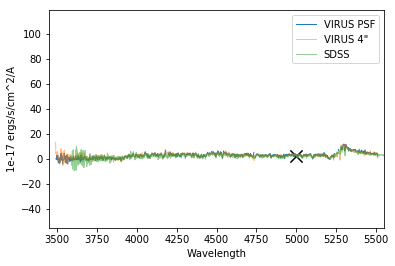

In [8]:
# PSF extraction
# For more help: help(E.build_weights)
weights = E.build_weights(xc, yc, ifux, ifuy, psf)
result = E.get_spectrum(data, error, mask, weights)
spectrum, spectrum_error = [res for res in result]

# Aperture Extraction
weights = E.build_weights(xc, yc, ifux, ifuy, aperture)
result = E.get_spectrum(data, error, mask, weights)
spectrum_aper, spectrum_aper_error = [res for res in result]

plt.plot(E.wave, spectrum, lw=1, label='VIRUS PSF')
plt.plot(E.wave, spectrum_aper, lw=1, alpha=0.5, label='VIRUS 4"')
plt.plot(10**(sp[index][1].data['loglam']), sp[index][1].data['flux'], lw=1, alpha=0.5, label='SDSS')
# G-mag for object
flam = 10**(-0.4 * (xid[index]['g']-23.9)) * 1e-29 * 3e18 / 5000.**2 * 1e17
plt.scatter(5000., flam, marker='x', color='k', s=150)
plt.xlim([3450, 5550])
plt.xlabel('Wavelength')
plt.ylabel('1e-17 ergs/s/cm^2/A')
plt.legend()